# Solutions

## Simulate DDS verilog module
> Plot the time domain waveform and its power spectrum density.

In [1]:
!make clean ph_acc.csv

rm -f ph_acc.csv dds.pdf dds_solution.pdf ph_acc.vcd ph_acc_tb
iverilog  -Wall -Wno-timescale -o ph_acc_tb ph_acc_tb.v ph_acc.v
vvp -N ph_acc_tb +of=ph_acc.csv
Recording output to file:           ph_acc.csv
phase_step_h:   182361
phase_step_l:      178
modulo:              2
Time: 65544 ns. cc =  8193. Done.


In [2]:
%matplotlib inline
from numpy.polynomial import polynomial
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dds import calc_dds, reg2freq

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

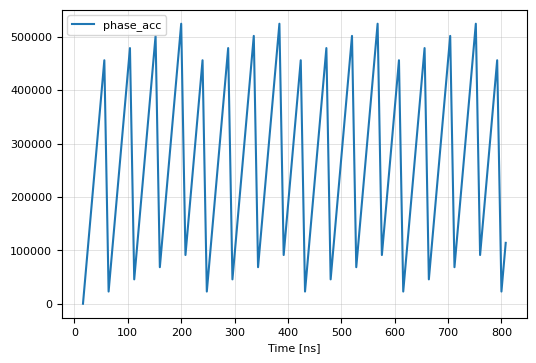

In [3]:
df = pd.read_csv('ph_acc.csv')
df[:100].plot(x='Time [ns]');

Peak frequency: 20.004 MHz


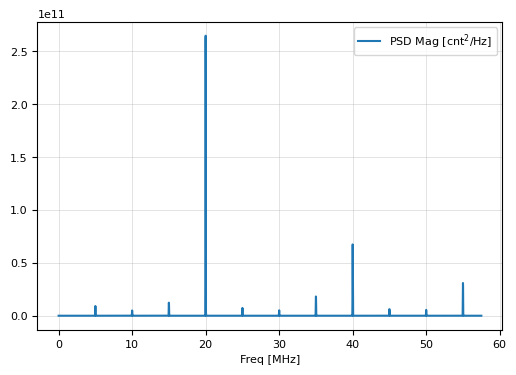

In [4]:
fs = 480 * 23 / 24 / 4  # MHz
f, psd = signal.periodogram(
    df['phase_acc'], fs, 'flattop', scaling='density')
df_psd = pd.DataFrame(
    {'Freq [MHz]': f, 'PSD Mag [cnt$^2$/Hz]': psd})
df_psd.plot(x='Freq [MHz]');
print(f'Peak frequency: {f[np.argmax(psd)]:.3f} MHz')

## Derive a different setting for LBNL ALS-U LLRF

> Calcuate new values of `ph`, `pl` and `modulo` for digital LO DDS.

In [5]:
num, den = 4, 11
fclk = 500e6 * 11 / 48  # Hz

ph, pl, modulo = calc_dds(num, den)
print(f'ph: {ph}, pl: {pl}, modulo: {modulo}')

ph: 381300, pl: 1488, modulo: 4


In [6]:
fdds = reg2freq(ph, pl, modulo, fclk)
print(f'DDS freq: {fdds/1e6:.3f} MHz')

major resolution:  109.275 Hz
minor resolution:  0.027 Hz
modulo resolution: 0.010 Hz
DDS freq: 41.667 MHz


## Rerun the DDS verilog simulation

> Re-run using your settings and check the new spectrum.

In [7]:
!vvp -N ph_acc_tb +of=ph_acc.csv +ph=381300 +pl=1488 +modulo=4

Recording output to file:           ph_acc.csv
phase_step_h:   381300
phase_step_l:     1488
modulo:              4
Time: 65544 ns. cc =  8193. Done.


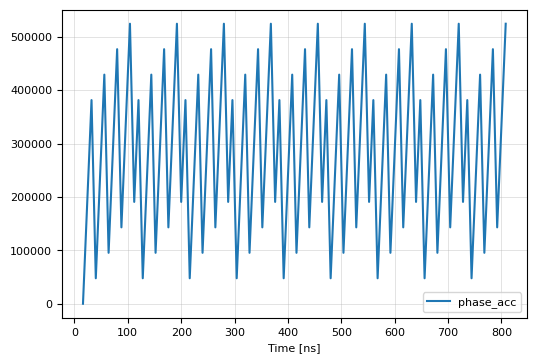

In [8]:
df = pd.read_csv('ph_acc.csv')
df[:100].plot(x='Time [ns]');

Peak frequency: 41.668 MHz


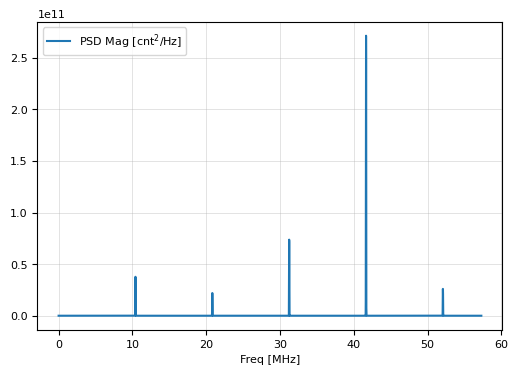

In [9]:
fs = fclk / 1e6  # MHz
f, psd = signal.periodogram(df['phase_acc'], fs, 'flattop', scaling='density')
df_psd = pd.DataFrame({'Freq [MHz]': f, 'PSD Mag [cnt$^2$/Hz]': psd})
df_psd.plot(x='Freq [MHz]');
print(f'Peak frequency: {f[np.argmax(psd)]:.3f} MHz')

## Build complete DDS with CORDIC

```verilog
     wire signed [18:0] cosd, sind;
     wire [18:0] dds_phase_acc;
     ph_acc dds_lo ( 
         .clk            (clk),
         .reset          (reset),
         .en             (1'b1), 
         .phase_acc      (dds_phase_acc),
         .phase_step_h   (dds_phase_step[31:12]),
         .phase_step_l   (dds_phase_step[11: 0]),
         .modulo         (dds_modulo)
     );
     
     cordicg_b22 #(.nstg(20), .width(18)) dds_cordicg_i(
         .clk            (clk),
         .opin           (2'b00), 
         .xin            (18'd74840),
         .yin            (18'd0),
         .phasein        (dds_phase_acc),
         .xout           (cosd),
         .yout           (sind)
     );
```